In [1]:
import os

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import dask.dataframe as dd

In [2]:
ds = xr.open_dataset('data/power_nasa_data.nc')

In [3]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:              (lat: 18, lon: 10, time: 8492)
Coordinates:
  * lat                  (lat) float64 144B 5.0 5.5 6.0 6.5 ... 12.5 13.0 13.5
  * lon                  (lon) float64 80B 36.25 36.88 37.5 ... 41.25 41.88
  * time                 (time) datetime64[ns] 68kB 2001-01-01 ... 2024-04-01
Data variables: (12/111)
    CDD0                 (time, lat, lon) float64 12MB ...
    CDD10                (time, lat, lon) float64 12MB ...
    CDD18_3              (time, lat, lon) float64 12MB ...
    DISPH                (time, lat, lon) float64 12MB ...
    EVLAND               (time, lat, lon) float64 12MB ...
    EVPTRNS              (time, lat, lon) float64 12MB ...
    ...                   ...
    SG_DAY_HOURS         (time, lat, lon) float64 12MB ...
    SG_NOON              (time, lat, lon) float64 12MB ...
    SZA                  (time, lat, lon) float64 12MB ...
    TOA_SW_DNI           (time, lat, lon) float64 12MB ...
    TOA_SW_DWN           (time, lat, lon) float64 12MB ...
    ZENITH_LUMINANCE     (time, lat, lon) float64 12MB ...

In [4]:
def count_missing_values(ds, missing_value_indicator=999.0):
    """
    Counts missing values in each data variable within an xarray Dataset.
    Missing values are identified as either NaN or a specified missing value indicator (e.g., 999.0).

    Parameters:
    - ds (xarray.Dataset): The dataset to analyze.
    - missing_value_indicator (float, optional): The numerical value used to indicate missing data.
      Defaults to 999.0.

    Returns:
    - dict: A dictionary where keys are the variable names and values are the counts of missing values.
    """
    missing_values_count = {}
    for var in ds.data_vars:
        # Counting NaN values
        nan_count = ds[var].isnull().sum().item()
        # Counting values equal to the specified missing value indicator
        custom_missing_count = (ds[var] == missing_value_indicator).sum().item()
        # Summing both counts to get the total number of missing values
        total_missing = nan_count + custom_missing_count
        missing_values_count[var] = total_missing
    return missing_values_count

In [5]:
def plot_missing_values_over_time(ds, variable_name, missing_value_indicator=999.0):
    """
    Plots the count of missing values over time for a specified variable in the dataset.

    Parameters:
    - ds (xarray.Dataset): The dataset containing the variable of interest.
    - variable_name (str): The name of the variable to analyze for missing values.
    - missing_value_indicator (float, optional): The numerical value used to indicate missing data.
      Defaults to 999.0.
    """
    # Select the variable of interest
    data = ds[variable_name]
    
    # Identify missing values (both NaN and custom indicator)
    missing_mask = data.isnull() | (data == missing_value_indicator)
    
    # Count missing values for each time point
    missing_counts = missing_mask.sum(dim=['lat', 'lon'])
    
    # Convert to Pandas DataFrame for easier plotting
    missing_df = missing_counts.to_dataframe(name='missing_count')
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(missing_df.index, missing_df['missing_count'], label=variable_name)
    plt.xlabel('Time')
    plt.ylabel('Count of Missing Values')
    plt.title(f'Missing Values Over Time for {variable_name}')
    plt.legend()
    plt.show()


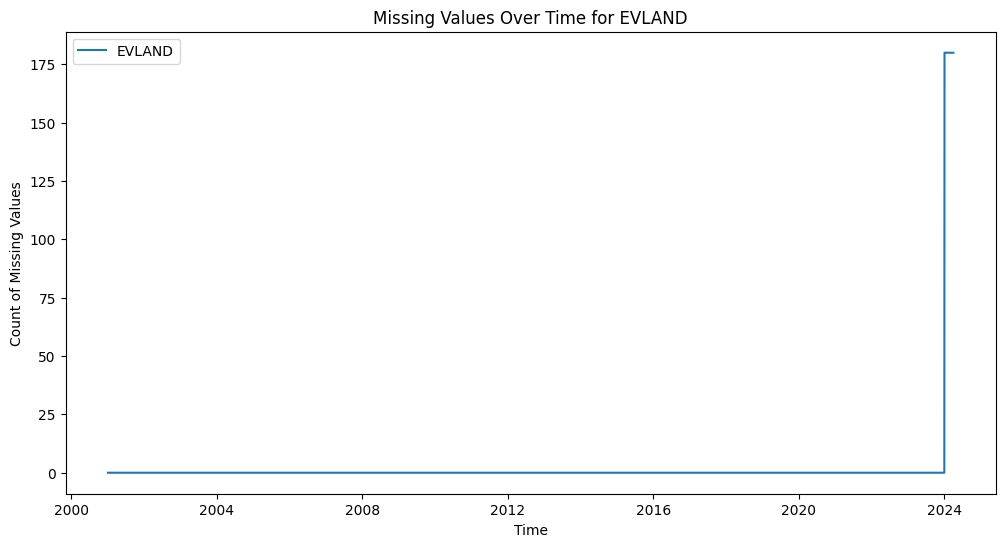

In [6]:
# Example usage
plot_missing_values_over_time(ds, 'EVLAND')

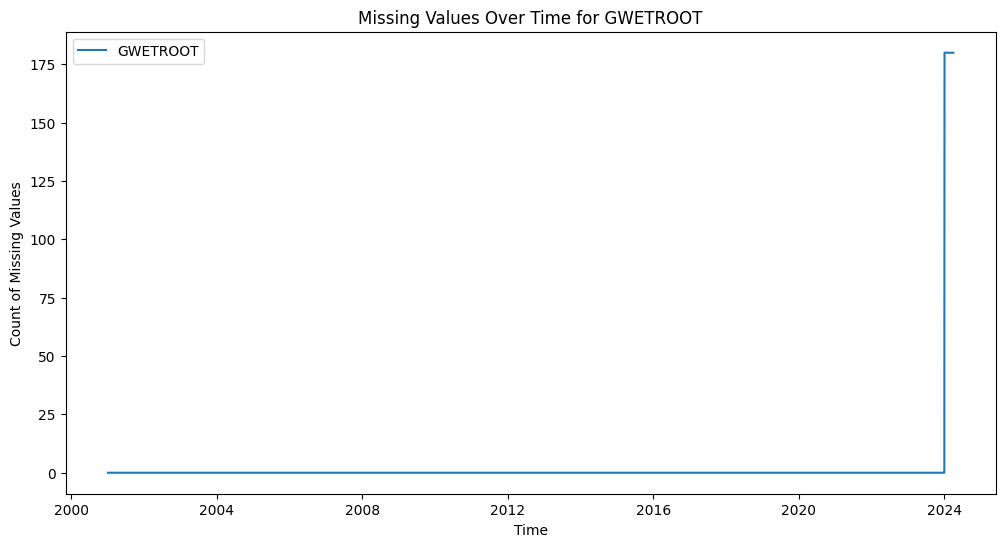

In [7]:
# Example usage
plot_missing_values_over_time(ds, 'GWETROOT')


latency in CERES they providing data with 3-4 months delay, last date 2023-11-30, information from POWER NASA team

In [8]:
def drop_rows_after_date(ds, cutoff_date):
    """
    Drops rows from an xarray Dataset after a specified cutoff date.

    Parameters:
    - ds (xarray.Dataset): The input dataset containing time-series data.
    - cutoff_date (str): The cutoff date in 'YYYY-MM-DD' format. Rows after this date will be dropped.

    Returns:
    - xarray.Dataset: The dataset with rows after the cutoff date removed.

    Example of usage:
    ds_filtered = drop_rows_after_date(ds, '2023-11-30')

    Author:
    - Adam Przychodni
    """
    # Convert the cutoff_date string to a pandas datetime object
    cutoff_datetime = pd.to_datetime(cutoff_date)
    
    # Use the .sel method to select rows on or before the cutoff date
    filtered_ds = ds.sel(time=slice(None, cutoff_datetime))
    
    return filtered_ds


In [9]:
# Example of usage
# Assuming 'ds' is your dataset loaded with xarray.open_dataset('power_nasa_data.nc')
ds_filtered = drop_rows_after_date(ds, '2023-11-30')

In [10]:
ds_filtered

<xarray.Dataset> Size: 1GB
Dimensions:              (lat: 18, lon: 10, time: 8369)
Coordinates:
  * lat                  (lat) float64 144B 5.0 5.5 6.0 6.5 ... 12.5 13.0 13.5
  * lon                  (lon) float64 80B 36.25 36.88 37.5 ... 41.25 41.88
  * time                 (time) datetime64[ns] 67kB 2001-01-01 ... 2023-11-30
Data variables: (12/111)
    CDD0                 (time, lat, lon) float64 12MB ...
    CDD10                (time, lat, lon) float64 12MB ...
    CDD18_3              (time, lat, lon) float64 12MB ...
    DISPH                (time, lat, lon) float64 12MB ...
    EVLAND               (time, lat, lon) float64 12MB 1.393e-06 ... 7.252e-06
    EVPTRNS              (time, lat, lon) float64 12MB ...
    ...                   ...
    SG_DAY_HOURS         (time, lat, lon) float64 12MB ...
    SG_NOON              (time, lat, lon) float64 12MB ...
    SZA                  (time, lat, lon) float64 12MB ...
    TOA_SW_DNI           (time, lat, lon) float64 12MB ...
    TOA_SW_DWN           (time, lat, lon) float64 12MB ...
    ZENITH_LUMINANCE     (time, lat, lon) float64 12MB ...

In [11]:
# Assuming 'ds' is your xarray Dataset
missing_values = count_missing_values(ds_filtered)

for variable, count in missing_values.items():
    print(f"{variable}: {count} missing values")

CDD0: 0 missing values
CDD10: 0 missing values
CDD18_3: 0 missing values
DISPH: 0 missing values
EVLAND: 0 missing values
EVPTRNS: 0 missing values
FROST_DAYS: 0 missing values
FRSEAICE: 0 missing values
FRSNO: 0 missing values
GWETPROF: 0 missing values
GWETROOT: 0 missing values
GWETTOP: 0 missing values
HDD0: 0 missing values
HDD10: 0 missing values
HDD18_3: 0 missing values
PBLTOP: 0 missing values
PRECSNOLAND: 0 missing values
PRECTOTCORR: 0 missing values
PS: 0 missing values
QV10M: 0 missing values
QV2M: 0 missing values
RH2M: 0 missing values
RHOA: 0 missing values
SLP: 0 missing values
SNODP: 0 missing values
T10M: 0 missing values
T10M_MAX: 0 missing values
T10M_MIN: 0 missing values
T10M_RANGE: 0 missing values
T2M: 0 missing values
T2MDEW: 0 missing values
T2MWET: 0 missing values
T2M_MAX: 0 missing values
T2M_MIN: 0 missing values
T2M_RANGE: 0 missing values
TO3: 0 missing values
TQV: 0 missing values
TROPPB: 0 missing values
TROPQ: 0 missing values
TROPT: 0 missing values

In [12]:
def drop_variables(ds, variables_to_drop):
    """
    Drops specified variables from an xarray Dataset.

    Parameters:
    - ds (xarray.Dataset): The input dataset from which variables will be dropped.
    - variables_to_drop (list of str): A list of strings representing the variable names to be dropped.

    Returns:
    - xarray.Dataset: The dataset with specified variables removed.

    Example of usage:
    variables_to_drop = ['PRECIPITATIONCAL', 'AIRMASS']
    ds_cleaned = drop_variables(ds, variables_to_drop)

    Author:
    - Adam Przychodni
    """
    # Use the .drop_vars method to remove specified variables
    cleaned_ds = ds.drop_vars(variables_to_drop)
    
    return cleaned_ds


In [13]:
# Example of usage
# Assuming 'ds' is your dataset loaded with xarray.open_dataset('power_nasa_data.nc')
variables_to_drop = ['PRECIPITATIONCAL', 'AIRMASS']
ds_cleaned = drop_variables(ds_filtered, variables_to_drop)

In [14]:
ds_cleaned

<xarray.Dataset> Size: 1GB
Dimensions:              (lat: 18, lon: 10, time: 8369)
Coordinates:
  * lat                  (lat) float64 144B 5.0 5.5 6.0 6.5 ... 12.5 13.0 13.5
  * lon                  (lon) float64 80B 36.25 36.88 37.5 ... 41.25 41.88
  * time                 (time) datetime64[ns] 67kB 2001-01-01 ... 2023-11-30
Data variables: (12/109)
    CDD0                 (time, lat, lon) float64 12MB 28.81 27.5 ... 28.12
    CDD10                (time, lat, lon) float64 12MB 18.81 17.5 ... 18.12
    CDD18_3              (time, lat, lon) float64 12MB 10.5 9.188 ... 12.0 9.812
    DISPH                (time, lat, lon) float64 12MB 0.25 0.2578 ... 0.03125
    EVLAND               (time, lat, lon) float64 12MB 1.393e-06 ... 7.252e-06
    EVPTRNS              (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.02344
    ...                   ...
    SG_DAY_HOURS         (time, lat, lon) float64 12MB 11.0 11.0 ... 11.0 11.0
    SG_NOON              (time, lat, lon) float64 12MB 9.625 9.625 ... 9.062
    SZA                  (time, lat, lon) float64 12MB 72.34 72.34 ... 74.46
    TOA_SW_DNI           (time, lat, lon) float64 12MB 703.9 703.9 ... 700.2
    TOA_SW_DWN           (time, lat, lon) float64 12MB 384.8 384.8 ... 344.6
    ZENITH_LUMINANCE     (time, lat, lon) float64 12MB 4.064e+03 ... 3.334e+03

In [15]:
# Assuming 'ds' is your xarray Dataset
missing_values = count_missing_values(ds_cleaned)

for variable, count in missing_values.items():
    print(f"{variable}: {count} missing values")

CDD0: 0 missing values
CDD10: 0 missing values
CDD18_3: 0 missing values
DISPH: 0 missing values
EVLAND: 0 missing values
EVPTRNS: 0 missing values
FROST_DAYS: 0 missing values
FRSEAICE: 0 missing values
FRSNO: 0 missing values
GWETPROF: 0 missing values
GWETROOT: 0 missing values
GWETTOP: 0 missing values
HDD0: 0 missing values
HDD10: 0 missing values
HDD18_3: 0 missing values
PBLTOP: 0 missing values
PRECSNOLAND: 0 missing values
PRECTOTCORR: 0 missing values
PS: 0 missing values
QV10M: 0 missing values
QV2M: 0 missing values
RH2M: 0 missing values
RHOA: 0 missing values
SLP: 0 missing values
SNODP: 0 missing values
T10M: 0 missing values
T10M_MAX: 0 missing values
T10M_MIN: 0 missing values
T10M_RANGE: 0 missing values
T2M: 0 missing values
T2MDEW: 0 missing values
T2MWET: 0 missing values
T2M_MAX: 0 missing values
T2M_MIN: 0 missing values
T2M_RANGE: 0 missing values
TO3: 0 missing values
TQV: 0 missing values
TROPPB: 0 missing values
TROPQ: 0 missing values
TROPT: 0 missing values

In [16]:
def count_missing_values_for_whole_ds(ds):
    """
    Counts the total number of missing values across all variables in an xarray Dataset.

    Parameters:
    - ds (xarray.Dataset): The input dataset.

    Returns:
    - int: The total number of missing values across all variables in the dataset.

    Example of usage:
    total_missing_values = count_missing_values(ds_cleaned)

    Author:
    - Adam Przychodni
    """
    # Use the isnull method to identify missing values, then sum them up
    missing_values_count = ds.isnull().sum().to_array().sum().item()
    
    return missing_values_count


In [17]:
# Example of usage
# Assuming 'ds_cleaned' is your dataset after variables have been dropped
total_missing_values = count_missing_values_for_whole_ds(ds_cleaned)
print(f"Total missing values in the dataset: {total_missing_values}")

Total missing values in the dataset: 0


In [18]:
ds_cleaned

<xarray.Dataset> Size: 1GB
Dimensions:              (lat: 18, lon: 10, time: 8369)
Coordinates:
  * lat                  (lat) float64 144B 5.0 5.5 6.0 6.5 ... 12.5 13.0 13.5
  * lon                  (lon) float64 80B 36.25 36.88 37.5 ... 41.25 41.88
  * time                 (time) datetime64[ns] 67kB 2001-01-01 ... 2023-11-30
Data variables: (12/109)
    CDD0                 (time, lat, lon) float64 12MB 28.81 27.5 ... 28.12
    CDD10                (time, lat, lon) float64 12MB 18.81 17.5 ... 18.12
    CDD18_3              (time, lat, lon) float64 12MB 10.5 9.188 ... 12.0 9.812
    DISPH                (time, lat, lon) float64 12MB 0.25 0.2578 ... 0.03125
    EVLAND               (time, lat, lon) float64 12MB 1.393e-06 ... 7.252e-06
    EVPTRNS              (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.02344
    ...                   ...
    SG_DAY_HOURS         (time, lat, lon) float64 12MB 11.0 11.0 ... 11.0 11.0
    SG_NOON              (time, lat, lon) float64 12MB 9.625 9.625 ... 9.062
    SZA                  (time, lat, lon) float64 12MB 72.34 72.34 ... 74.46
    TOA_SW_DNI           (time, lat, lon) float64 12MB 703.9 703.9 ... 700.2
    TOA_SW_DWN           (time, lat, lon) float64 12MB 384.8 384.8 ... 344.6
    ZENITH_LUMINANCE     (time, lat, lon) float64 12MB 4.064e+03 ... 3.334e+03

In [19]:
ds_cleaned = ds_cleaned.rename({"time": "timestamp"})

In [20]:
# ADDING ITEM_ID FOR AUTOGLUON POSSIBLY

# import numpy as np

# # Assuming ds_cleaned is your xarray.Dataset
# latitudes = ds_cleaned.lat.values
# longitudes = ds_cleaned.lon.values

# # Calculate the total number of latitudes and longitudes
# n_lat = len(latitudes)
# n_lon = len(longitudes)

# # Create an array of integers representing each unique lat-lon pair
# # This essentially numbers each grid point based on its position
# item_ids = np.arange(n_lat * n_lon).reshape(n_lat, n_lon)

# # Convert the array of item_ids into a DataArray, with the same lat and lon dimensions
# item_id_da = xr.DataArray(item_ids, coords=[("lat", latitudes), ("lon", longitudes)])

# # Adding the item_id DataArray to the dataset
# ds_cleaned['item_id'] = item_id_da


In [21]:
# ds_cleaned

# Experiment 0.01
## Potential Target Variables:
In Ethiopia, where agriculture heavily relies on precise water management, accurately predicting soil wetness at different depths—GWETROOT, GWETPROF, and GWETTOP—is crucial. These variables provide essential data on surface and sub-surface moisture levels, enabling optimal decision-making for crop planting, irrigation scheduling, and drought management. Currently, these are experimental metrics; we will determine which variable is most effective for our applications through ongoing research and testing.

## Features:
### Hydrological Inputs and Outputs
- Precipitation (PRECTOTCORR): The primary source of water for soil in Botswana and Zimbabwe, essential for replenishing soil moisture. Precipitation directly increases GWETROOT, making it a pivotal variable for predicting changes in soil moisture levels.

- Evapotranspiration (EVPTRNS): Represents water loss from the soil through evaporation and from plants through transpiration. It's a significant factor in soil moisture depletion, especially during warm and sunny conditions typical of these regions. Modeling evapotranspiration aids in understanding the outflow of water from the soil system, balancing the input from precipitation.

### Climatic and Atmospheric Conditions
- Air Temperature (T2M) and Surface Temperature (TS): Both influence the rate of evaporation and plant transpiration. Higher temperatures can lead to increased evaporation rates, thereby reducing GWETROOT. They are indicators of the energy available for water to transition from liquid to vapor.

- Solar Radiation (ALLSKY_SFC_SW_DWN): Drives evaporation by providing the necessary energy. It directly impacts how quickly soil moisture can decrease under sunny conditions versus how it might be conserved on cloudier days.

- Cloud Cover (CLOUD_AMT): Influences the amount of solar radiation that reaches the surface, thus affecting evaporation rates. Additionally, cloud cover is often associated with precipitation events, providing indirect clues about potential increases in soil moisture.

- Surface Pressure (PS): Changes in surface pressure can indicate incoming weather systems that might alter precipitation patterns, temperature, and cloud cover, thereby affecting soil moisture levels indirectly.

### Wind and Humidity Dynamics
- Wind Speed at 2 Meters (WS2M) and Wind Speed at 10 Meters (WS10M): Wind enhances evaporation by moving moist air away from the soil surface and facilitating the arrival of drier air. This process can significantly impact the rate at which soil moisture is lost to the atmosphere.

- Specific Humidity at 2 Meters (QV2M): Higher humidity levels can reduce the gradient between the moisture in the soil and the air, potentially lowering the rate of evaporation. This variable helps in understanding the atmospheric demand for moisture from the soil.

- Relative Humidity at 2 Meters (RH2M): Offers insights into the moisture content of the air near the soil surface. Low relative humidity indicates a higher potential for evaporation, leading to faster depletion of soil moisture.

### Enhanced Solar Radiation Measurement
- All Sky Surface Shortwave Downward Irradiance (ALLSKY_SFC_SW_DWN): Provides a detailed measure of solar energy reaching the ground, factoring in cloud cover and atmospheric conditions. This nuanced view helps in estimating the potential for soil warming and drying, crucial for predicting changes in GWETROOT.

## Summary of the selection:

Direct Influences: Precipitation (PRECTOTCORR) and Evapotranspiration (EVPTRNS) represent the most direct inputs and outputs of water in the soil system, crucial for any soil moisture model.

Climatic Factors: Temperature (T2M, TS), Solar Radiation (ALLSKY_SFC_SW_DWN), and Specific Humidity (QV2M) are vital for understanding the energy balance and moisture capacity of the air, which directly impacts evaporation rates and soil moisture replenishment.

Modulating Effects: Wind Speed (WS2M, WS10M) and Cloud Cover (CLOUD_AMT) can modulate evaporation rates and precipitation patterns, thereby influencing soil moisture indirectly.

Atmospheric Conditions: Surface Pressure (PS) and Relative Humidity (RH2M) offer insights into broader weather patterns and the atmospheric moisture content, respectively, which can indicate potential changes in soil moisture availability.

Enhanced Solar Radiation Measurement: ALLSKY_SFC_SW_DWN provides a more detailed view of the solar energy reaching the Earth's surface, considering atmospheric conditions, thus offering nuanced insights into the potential for soil drying or warming.

In [22]:
variables = [ 
    # 'item_id', # ID of the region 
    'PRECTOTCORR', 'EVPTRNS',  # Hydrological Inputs and Outputs
    'T2M', 'TS', 'CLOUD_AMT', 'PS',  # Climatic and Atmospheric Conditions
    'WS2M', 'WS10M', 'QV2M', 'RH2M',  # Wind and Humidity Dynamics 
    'ALLSKY_SFC_SW_DWN', # Enhanced Solar Radiation Measurement
    'GWETROOT', 'GWETPROF', 'GWETTOP' # Potential soil target variables
]

# Assuming ds_cleaned is the xarray dataset, we select the features in the specified order
ds_selected_variables = ds_cleaned[variables]

In [23]:
ds_selected_variables

<xarray.Dataset> Size: 169MB
Dimensions:            (timestamp: 8369, lat: 18, lon: 10)
Coordinates:
  * lat                (lat) float64 144B 5.0 5.5 6.0 6.5 ... 12.5 13.0 13.5
  * lon                (lon) float64 80B 36.25 36.88 37.5 ... 40.62 41.25 41.88
  * timestamp          (timestamp) datetime64[ns] 67kB 2001-01-01 ... 2023-11-30
Data variables: (12/14)
    PRECTOTCORR        (timestamp, lat, lon) float64 12MB 0.0 5.239e-10 ... 0.0
    EVPTRNS            (timestamp, lat, lon) float64 12MB 0.0 0.0 ... 0.02344
    T2M                (timestamp, lat, lon) float64 12MB 301.5 300.4 ... 300.9
    TS                 (timestamp, lat, lon) float64 12MB 303.2 302.1 ... 303.2
    CLOUD_AMT          (timestamp, lat, lon) float64 12MB 18.7 18.7 ... 22.62
    PS                 (timestamp, lat, lon) float64 12MB 9.345e+04 ... 9.725...
    ...                 ...
    QV2M               (timestamp, lat, lon) float64 12MB 0.005249 ... 0.01233
    RH2M               (timestamp, lat, lon) float64 12MB 22.75 22.12 ... 53.94
    ALLSKY_SFC_SW_DWN  (timestamp, lat, lon) float64 12MB 274.0 274.0 ... 236.1
    GWETROOT           (timestamp, lat, lon) float64 12MB 0.4062 ... 0.375
    GWETPROF           (timestamp, lat, lon) float64 12MB 0.4062 ... 0.375
    GWETTOP            (timestamp, lat, lon) float64 12MB 0.1562 ... 0.2656

In [24]:
output = r'' # if none the location of the script is where the files will be outputted.

# export region as NetCDF4
ds_selected_variables.to_netcdf(path=os.path.join(output, "data/preprocessed_power_nasa_data.nc"))